# Check output of SMICA for residuals, on map and powerspectrum level 

## Header

In [1]:
%%capture
import numpy as np
import pandas as pd
from healpy.sphtfunc import smoothing
import smica
import os
import matplotlib.gridspec as gridspec
import json
import copy
from astropy.io import fits
from scipy import interpolate

import healpy as hp
import component_separation
from component_separation.io import IO
import component_separation.interface as cslib
import component_separation.MSC.MSC.pospace as ps
import component_separation.powspec as pw

import component_separation.transform_map as trsf_m
from component_separation.cs_util import Config
from component_separation.cs_util import Constants as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Planckf, Planckr, Plancks
import matplotlib.pyplot as plt
csu = Config()
io = IO(csu)
import warnings
warnings.filterwarnings('ignore')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.PLANCKMAPFREQ_f
specfilter = csu.specfilter
freqfilter = csu.freqfilter
colors=csu.CB_color_cycle
bcorr = np.array([
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ])
beam5 = hp.gauss_beam(0.00145444, lmax, pol = True)[:,1]
beam5_binned = hpf.bin_it1D(beam5, bins=bins)
cfc = copy.deepcopy(csu.cf)
cfc['pa']['freqdset'] = 'NPIPE'
cfc['pa']['mskset'] = 'smica'
csuc = Config(cfc)
ioc = IO(csuc)
beamfNPIPE = ioc.load_beamf(freqcomb=csu.freqcomb)
cfc = copy.deepcopy(csu.cf)
cfc['pa']['freqdset'] = 'DX12'
cfc['pa']['mskset'] = 'smica'
csuc = Config(cfc)
ioc = IO(csuc)
beamfDX12 = ioc.load_beamf(freqcomb=csu.freqcomb)

In [2]:
CMB_n = io.load_data(io.fh.map_cmb_sc_path_name)
MV_n = io.load_data(io.fh.cmbmap_smica_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)

W_smica = io.load_data(io.fh.weight_smica_path_name)
W_mv = io.load_data(io.fh.weight_path_name)
W_total_smica = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)

pure_cmb_cl = io.load_data(io.fh.signal_sc_path_name)
pure_cmb_map = io.load_data(io.fh.map_cmb_sc_path_name)
smica_cmb_cl = io.load_data(io.fh.cmb_specsmica_sc_path_name)
smica_gal_cl = io.load_data(io.fh.gal_specsmica_sc_path_name)
smica_gal_mixmat = io.load_data(io.fh.out_specsmica_path+"gal_mixmat_{}".format("SMICA_highell_bins") + "_" + io.fh.total_filename)

C_ltot = io.load_powerspectra('full')
TSCALE = "K_RJ"
cov_ltot = pw.build_covmatrices(C_ltot, TSCALE, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_ltotEE = cov_ltot[1]
print(cov_ltotEE.shape)

C_lN = io.load_powerspectra('noise')
cov_lN = pw.build_covmatrices(C_lN, TSCALE, csu.freqcomb, csu.PLANCKMAPFREQ_f)
cov_lNEE = cov_lN[1]
for n in range(cov_lNEE.shape[0]):
    for m in range(cov_lNEE.shape[1]):
        if n != m:
            cov_lNEE[n,m] = np.zeros(shape=cov_lNEE.shape[2])
print(cov_lNEE.shape)

loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/smicaminvarmap_SMICA_highell_bins_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/SMICAWEIG_K_CMB_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/weights/NPIPE/WEIG_K_CMB_0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/misc/C_lS_in_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/misc/map_cmb_in_nside_2048_sim_id_0200.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/CMB_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/GAL_SPECSMICA_SMICA_highell_bins0200_C_l_NPIPE_smica_4000_6000_0_0_Full.npy
loaded /global/cscratch1/sd/sebibel/smica/NPIPE/gal_mixmat_S

SystemExit: 

In [3]:
%tb

SystemExit: 

# Load Maudes DX12 results and compare
Comparison only sensible when data is in $K_{RJ}$ scale

In [ ]:
md_N = np.loadtxt("/global/homes/s/sebibel/data/maude/N.txt").reshape(7,37)
md_A = np.loadtxt("/global/homes/s/sebibel/data/maude/A.txt").reshape(7,7)

md_P = np.loadtxt("/global/homes/s/sebibel/data/maude/P.txt").reshape(7,7,37)

md_hR = np.loadtxt("/global/homes/s/sebibel/data/maude/hR_binned_full.txt").reshape(7,7,37)
md_Rl = np.loadtxt("/global/homes/s/sebibel/data/maude/Rl.txt").reshape(7,7,4001)

md_w_raw = np.loadtxt("/global/homes/s/sebibel/data/maude/raw_filter_cmb_full.txt").reshape(2,7,4001)
md_w_mc = np.loadtxt("/global/homes/s/sebibel/data/maude/mc_filter_cmb_full.txt").reshape(2,7,4001)
md_w = np.loadtxt("/global/homes/s/sebibel/data/maude/w_binned_full.txt")

md_bins = np.loadtxt("/global/homes/s/sebibel/data/maude/bins.txt")

## Covariance, md_Rl

NameError: name 'cov_ltotEE' is not defined

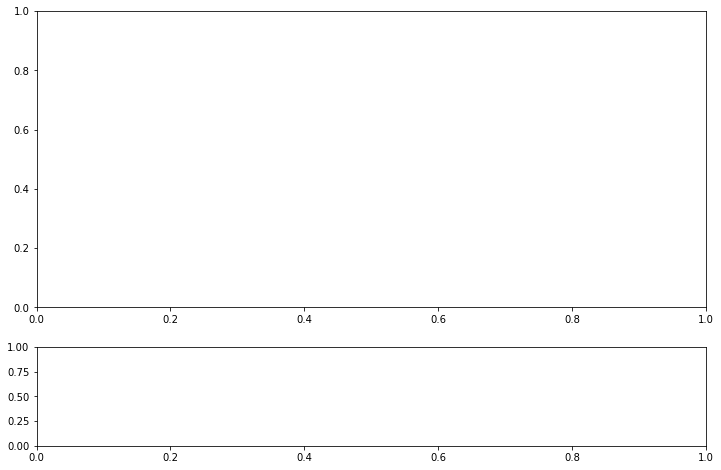

In [5]:
from scipy.signal import savgol_filter as sf
# ax = plt.figure(constrained_layout=True).subplots(2,1, sharex=True)
plt.figure(figsize=(12,8))

gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
for n in range(0,md_P.shape[0]):
    for m in range(0,md_P.shape[0]):
        if n == m:
            ax0.plot(np.nan_to_num(cov_ltotEE[n,m,:4001]*1e-6), color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
            # ax0.plot(sf(np.nan_to_num(cov_ltotEE[n,m,:4001]),9,2), color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
            ax0.plot(md_Rl[n,m,:]*1e6/beam5**2, color=colors[m], ls= '--')
            
            buff = (cov_ltotEE[n,m,:4001]-md_Rl[n,m,:]*1e6/beam5**2)/(md_Rl[n,m,:]*1e6/beam5**2)
            buff[np.isnan(buff)] = 1e-3
            buff[buff<0] = 1e-3
            ax1.plot(sf(buff,151,2), color=colors[n], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))

ax0.legend()
ax0.set_yscale('log')
ax0.set_xscale('log')
ax0.set_xlim((1e1,5e3))
# ax0.set_ylim((1e-3,1e2))
ax0.set_title('Powerspectrum per Frequency')
ax1.set_xlabel('Multipole')
ax0.set_ylabel('Powerspectrum')
ax1.set_ylabel('Rel. Diff.')
ax1.set_ylim((1e-2,2e1))
ax1.set_xlim((1e1,5e3))
ax1.set_xscale('log')
ax1.set_yscale('log')

In [ ]:
#%matplotlib widget
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
from scipy.signal import savgol_filter as sf
for n in range(3,4):
    for m in range(md_P.shape[0]):
         if n <= m:
            ax0.plot(sf(np.nan_to_num((cov_ltotEE[n,m,:4001]-md_Rl[n,m,:]*1e6/beam5**2)/(md_Rl[n,m,:]*1e6/beam5**2)),99,3), color=colors[m], label="{}-{}".format(csu.PLANCKMAPFREQ[n],csu.PLANCKMAPFREQ[m]))
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.xlim((1e1,5e3))
plt.title('Powerspectrum per Frequency')
plt.xlabel('Multipole')
plt.ylabel('Relative difference')

## Bins

In [6]:
%matplotlib widget
for n in range(md_bins[:].shape[0]):
    plt.plot(md_bins[n,:], [1e2,1e2], lw=4)
plt.yscale('log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Noise

Text(0.5, 0, 'Multipole')

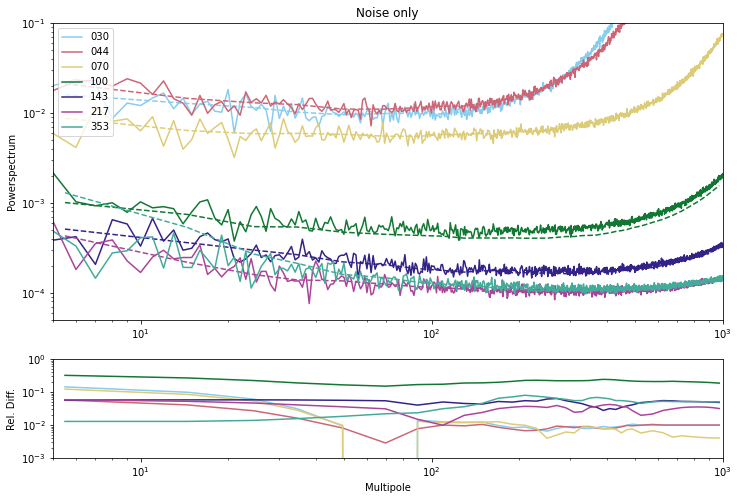

In [14]:
#%matplotlib widget
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
for n in range(md_N.shape[0]):
    ax0.plot(cov_lN[1,n,n], color=colors[n], label="{}".format(csu.PLANCKMAPFREQ[n]))
    ax0.plot(np.mean(bins, axis=1), md_N[n]/beam5_binned**2*1e6, color=colors[n], ls='--')
    buff = (hpf.bin_it1D(cov_lN[1,n,n],bins=bins)-md_N[n]/beam5_binned**2*1e6)/(md_N[n]/beam5_binned**2*1e6)
    buff[np.isnan(buff)]=1e-2
    buff[buff<0]=1e-2
    ax1.plot(np.mean(bins, axis=1), sf(buff,11,2),color=colors[n])
ax0.set_title('Noise only')
ax0.legend()    
ax0.set_yscale('log')
ax1.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax0.set_ylim((5e-5,1e-1))
ax1.set_ylim((1e-3,1e0))
ax0.set_ylabel('Powerspectrum')
ax1.set_ylabel('Rel. Diff.')
ax0.set_xlim((5,1e3))
ax1.set_xlim((5,1e3))
ax1.set_xlabel('Multipole')

## W_ell hR_ell W_ell^T

In [23]:
lmaxbin = lmax#len(bins)
res_tot_M = np.zeros(shape=(lmaxbin))
res_tot_S = np.zeros(shape=(lmaxbin))
for l in range(lmaxbin):
    res_tot_M[l] = np.dot(np.dot((md_w_mc[0,:,l]*np.diag(beamfDX12[1,:,:,l])/(beam5[l])).T,md_Rl[:,:,l]*1e6/beam5[l]**2),md_w_mc[0,:,l]*np.diag(beamfDX12[1,:,:,l])/(beam5[l]))
    res_tot_S[l] = np.dot(np.dot(W_total_smica[1,:,l].T,cov_ltotEE[:,:,l]),W_total_smica[1,:,l])

Text(0.5, 0, 'Powerspectrum')

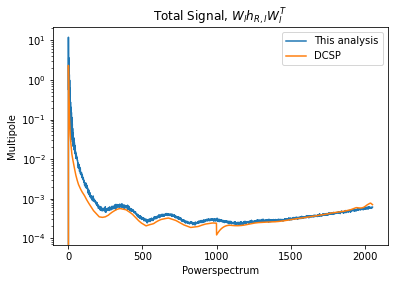

In [24]:
#%matplotlib widget
plt.plot(res_tot_S, label = 'This analysis')
plt.plot(res_tot_M, label = 'DCSP')
# plt.plot(np.mean(bins, axis=1), md_Rs)
plt.legend()
plt.yscale('log')
plt.title(r'Total Signal, $W_l h_{R,l} W_l^T$')
plt.ylabel('Multipole')
plt.xlabel('Powerspectrum')

In [25]:
lmaxbin = lmax
md_Rs = np.zeros(shape=(37))

md_Ps = md_P[0,0,:]
md_As = md_A[:,0] 
print(md_P.shape, md_A.shape)
print(md_Ps.shape, md_As.shape)
print(md_As)
for l in range(0,37):
    md_Rs[l] = np.dot(md_As* bf_binned[:,l]/beam5_binned[l],md_As*bf_binned[:,l]/beam5_binned[l]) * md_Ps[l] *1e6/beam5_binned[l]**2

(7, 7, 37) (7, 7)
(37,) (7,)
[9.77074575e-04 9.51460365e-04 8.84163388e-04 7.77300011e-04
 6.04840290e-04 3.34425013e-04 7.75485398e-05]


## W_ell N_ell W_ell^T

In [16]:
lmaxbin = lmax#len(bins)
res_N_M = np.zeros(shape=(37))
res_N_S = np.zeros(shape=(lmaxbin))
cov_md_N = np.zeros(shape = (7,7,37))
md_w_mc_binned = np.zeros(shape=(7,37))
bf_binned = np.array([hpf.bin_it1D(beamfDX12[1,n,n,:], bins=bins) for n in range(beamfDX12.shape[1])])
for n in range(md_w_mc_binned.shape[0]):
    md_w_mc_binned[n] = hpf.bin_it1D(md_w_mc[0,n,:], bins=bins) #*bcorr[n]/(beam5)
for l in range(37):
    np.fill_diagonal(cov_md_N[:,:,l], md_N[:,l])
for l in range(37):
    res_N_M[l] = np.dot(np.dot((md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l]).T,cov_md_N[:,:,l]*1e6/beam5_binned[l]**2),md_w_mc_binned[:,l]*bf_binned[:,l]/beam5_binned[l])

for l in range(lmaxbin):
    res_N_S[l] = np.dot(np.dot(W_total_smica[1,:,l].T,cov_lNEE[:,:,l]),W_total_smica[1,:,l])

Text(0.5, 0, 'Multipole')

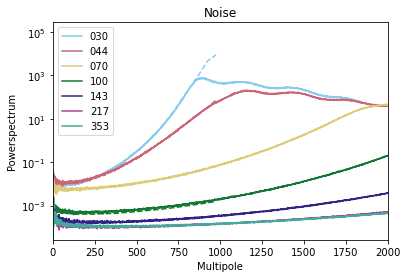

In [18]:
#%matplotlib widget
for n in range(7):
    plt.plot(cov_lNEE[n,n,:], color=colors[n], label=csu.PLANCKMAPFREQ[n],)
    plt.plot(np.mean(bins, axis=1), cov_md_N[n,n,:]*1e6/beam5_binned[:]**2, color=colors[n], ls = '--')
    
plt.yscale('log')
plt.title('Noise')
plt.xlim((0,2000))
plt.legend()
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')

Text(0.5, 0, 'Multipole')

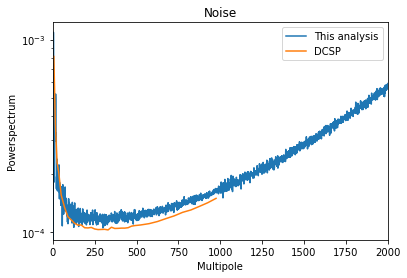

In [19]:
#%matplotlib widget
plt.plot(res_N_S, label='This analysis')
plt.plot(np.mean(bins, axis=1), res_N_M, label='DCSP')
plt.yscale('log')
plt.title('Noise')
plt.xlim((0,2000))
plt.legend()
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')

In [15]:
map_N_S = hp.synfast(res_N_S, 2048)

In [18]:
hp.mollview(map_N_S)
np.save('/global/cscratch1/sd/sebibel/smica/smicaminvarmap_Noise_SMICA_highell_bins_0200_C_l_NPIPE_lens_4000_6000_0_0_Full.npy', map_N_S)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## W_ell Rg_ell W_ell^T

In [26]:
lmaxbin = lmax
md_Rg = np.zeros(shape=(7,7,37))
cov_gal = np.zeros(shape=(7,7,len(bins)))
for l in range(37):
    cov_gal[:,:,l] = smica_gal_mixmat[0] @ smica_gal_cl[0,:,:,l] @ smica_gal_mixmat[0].T

md_Pg = md_P[1:,1:,:]
md_Ag = md_A[:,1:] 
print(md_Ag.shape, md_Pg.shape)
for l in range(0,37):
    md_Rg[:,:,l] = md_Ag @ md_Pg[:,:,l] @ md_Ag.T

(7, 6) (6, 6, 37)


Text(0.5, 0, 'Mutlipole')

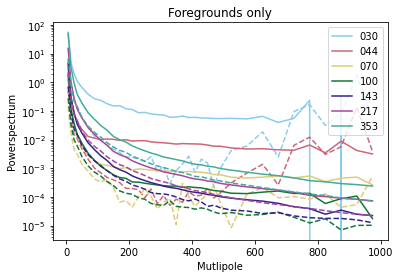

In [27]:
#%matplotlib widget
import component_separation.spherelib.python.spherelib.astro as slhpastro
cov_gal_fac = np.zeros_like(cov_gal)
for n in range(7):
    factor = slhpastro.convfact(freq=int(csu.PLANCKMAPFREQ[n])*1e9, fr='K_CMB',to=TSCALE)
    cov_gal_fac[n,n] = cov_gal[n,n]*factor**2
for n in range(7):
    plt.plot(np.mean(bins, axis=1), cov_gal_fac[n,n,:], color=colors[n], label=csu.PLANCKMAPFREQ[n])
    plt.plot(np.mean(bins, axis=1), md_Rg[n,n,:]*1e6/beam5_binned**2, color=colors[n], ls = '--')
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.title('Foregrounds only')
plt.ylabel('Powerspectrum')
plt.xlabel('Mutlipole')


In [28]:
res_G_M = np.zeros(shape=(37))
res_G_S = np.zeros(shape=len(bins))
md_Rg_buf = np.zeros_like(md_Rg)

for n in range(7):
    md_Rg_buf[n,n,:] = md_Rg[n,n,:]*1e6/beam5_binned**2
for l in range(37):
    res_G_S[l] = np.dot(np.dot(W_smica[1,:,l].T,cov_gal_fac[:,:,l]),W_smica[1,:,l])
#     res_G_S[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg_buf[:,:,l]),W_smica[1,:,l])

md_w_mc_beamed = np.zeros(shape=(7,4001))
for l in range(0,4001):
    for n in range(0,7):
        md_w_mc_beamed[n,l] = md_w_mc[0,n,l] * bcorr[n,l]/beam5[l]
md_w_mc_beamed_bnd = np.zeros(shape=(7,37))
for n in range(0,7):
    md_w_mc_beamed_bnd[n] = hpf.bin_it1D(md_w_mc_beamed[n], bins=bins)
for l in range(37):
    res_G_M[l] = np.dot(np.dot(md_w_mc_beamed_bnd[:,l].T,md_Rg_buf[:,:,l]),md_w_mc_beamed_bnd[:,l])
#     res_G_M[l] = np.dot(np.dot(W_smica[1,:,l].T,md_Rg[:,:,l]*1e6/beam5_binned[l]**2),W_smica[1,:,l])
#     res_G_M[l] = np.dot(np.dot(md_w_mc_beamed[:,l].T,md_Rg[:,:,l]*1e6),md_w_mc_beamed[:,l])

Text(0.5, 1.0, 'Residual Foreground, $W_l R_{g,l} W_l^T$')

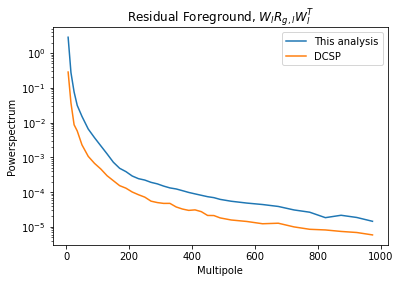

In [29]:
#%matplotlib widget
# for n in range(7):
#     plt.plot(cov_gal[n,n])
plt.plot(np.mean(bins, axis=1), res_G_S, label='This analysis')
plt.plot(np.mean(bins, axis=1), res_G_M, label='DCSP')
plt.title('Residual foreground')
plt.legend()
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')
plt.yscale('log')
plt.title(r'Residual Foreground, $W_l R_{g,l} W_l^T$')

In [20]:
%matplotlib widget
W_smica.shape
for n in range(7):
    plt.plot(np.mean(bins, axis=1), W_smica[1,n,:], color= colors[n],label=csu.PLANCKMAPFREQ[n])
    plt.plot(np.mean(bins, axis=1), md_w_mc_beamed_bnd[n,:], color= colors[n], ls = '--')
plt.title('DX12, this analysis vs DCSP')
plt.xlabel('Mutlipole')
plt.ylabel('Weighting')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# All Residuals in one plot

## Mine
The following plot is only consistent when data is in $K_{CMB}$ scale

K_RJ


Text(0, 0.5, 'Powerspectrum')

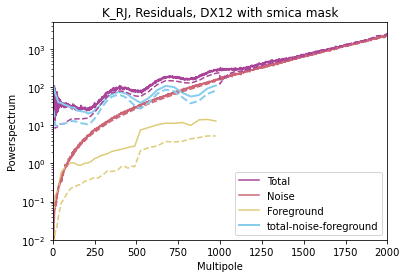

In [30]:
#%matplotlib widget
def ll(l):
    return (l*(l+1))
print(TSCALE)
bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))

plt.plot(res_tot_S*all_ell, label='Total', color = colors[5])
plt.plot(res_N_S*all_ell, label='Noise', color = colors[1])
plt.plot(np.mean(bins, axis=1), res_G_S*md_w*1e-5*bin_ell, label='Foreground', color = colors[2])
plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S*md_w*1e-5)*bin_ell, label='total-noise-foreground', color = colors[0], lw = 2)

plt.plot(res_tot_M*all_ell, color = colors[5], ls = '--')
plt.plot(np.mean(bins, axis=1), res_N_M*bin_ell, color = colors[1], ls = '--')
plt.plot(np.mean(bins, axis=1), res_G_M*md_w*1e-5*bin_ell, color = colors[2], ls = '--')
plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_M, bins=bins)-res_N_M-res_G_M*md_w*1e-5)*bin_ell, color = colors[0], lw = 2, ls = '--')
# plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0]*bin_ell, label='SMICA best fit', color = colors[3], ls = '--')
# plt.plot(pure_cmb_cl[0,1,:4000]*all_ell, label='Planck best fit', color = colors[3], alpha=0.2, lw = 1)
# plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0]*bin_ell, color= 'black', lw=1, label='SMICA best fit')
# plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-2,5e3))
plt.xlim((0,2000))
plt.title('{}, Residuals, {} with {} mask'.format(TSCALE, csu.cf['pa']['freqdset'], csu.cf['pa']['mskset']) )
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

## Maude TBD
Maudes data is D_l in K_RJ scale

In [62]:
%matplotlib widget
def ll(l):
    return (l*(l+1))

bin_ell = ll(np.mean(bins, axis=1))
all_ell = ll(np.arange(0,4000,1))
plt.plot(res_tot_M*all_ell, label='Total', color = colors[2])
plt.plot(np.mean(bins, axis=1), res_N_M*bin_ell, label='Res. Noise', color = colors[1])
plt.plot(np.mean(bins, axis=1), res_G_M*md_w*1e-5*bin_ell, label='Res. galactic', color = colors[0])
# plt.plot(np.mean(bins, axis=1), (hpf.bin_it1D(res_tot_S, bins=bins)-hpf.bin_it1D(res_N_S, bins=bins)-res_G_S)*bin_ell, label='Res. Signal', color = colors[3], lw = 2)
# plt.plot(np.mean(bins, axis=1), smica_cmb_cl[0]*bin_ell, label='SMICA best fit', color = colors[3], ls = '--')
# plt.plot(pure_cmb_cl[0,1,:4000]*all_ell, label='Planck best fit', color = colors[3], alpha=0.2, lw = 1)
plt.yscale('log')
# plt.xscale('log')
plt.ylim((1e-2,5e3))
plt.xlim((5,2000))
plt.title('Residuals DCSP')
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Powerspectrum')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Powerspectrum')

# Compare weights (DX12 smica only)
W_smica = io.load_data(io.fh.weight_smica_path_name)
 * "- raw_filter_cmb_full.txt: weights derived from the fit (A^T R-1 A)^-1 A^T R^-1"
 * md_w_mc looks familiar
 * md_w = what is that?

In [12]:
%matplotlib widget
print(md_w_raw.shape)
print(md_w_mc.shape)
print(md_w.shape)
for freq in range(md_P.shape[0]):
    
    #This is the fitting result
    plt.plot(np.mean(bins, axis=1), W_smica[0,freq,:], color=colors[freq], label=csu.PLANCKMAPFREQ[freq], lw=3)
    plt.plot(W_total_smica[1,freq,:], color=colors[freq], lw=3, alpha=0.1)
    plt.plot(md_w_mc[0,freq,:]*bcorr[freq]/(beam5), color=colors[freq], lw=1, ls='--')
#     plt.plot(np.mean(bins, axis=1), W_smica[1,freq,:], color=colors[freq], lw=1, ls='--')
# plt.plot(np.mean(bins, axis=1), md_w)
# plt.yscale('log')
plt.title('DX12 smica weights vs Maudes weights')
plt.ylabel('Weight')
plt.xlabel('Multipole')
plt.legend(loc='upper right')
plt.ylim((-0.1,1.0))
plt.show()

(2, 7, 4001)
(2, 7, 4001)
(37,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [23]:
%matplotlib widget
for n in range(0,7):
    plt.plot(md_w_raw[0,n])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Derive Maudes weights etc.
md_R = md_hR = md_Rl[:1000]

BUT why are 217 and 353 constant for high ell?

In [4]:
md_fg = np.zeros(shape=(7,7,37))
md_R = np.zeros(shape=(7,7,37))
AP = np.zeros(shape=(7,7,37))
for l in range(0,37):
    AP[1,:,l] = np.dot(md_A, md_P[:,:,l])
    md_fg[:,:,l] = np.dot(AP[:,:,l], md_A.T)
for l in range(0,37):
    for n in range(0,7):
        md_R[n,n,l] = md_fg[n,n,l]# + md_N[n,l]

ValueError: could not broadcast input array from shape (7,7) into shape (7)

In [9]:
%matplotlib widget
for n in range(7):
    plt.plot(np.mean(bins, axis=1), md_R[n,n,:], color=colors[n],label = csu.PLANCKMAPFREQ[n])
#     plt.plot(md_Rl[n,n,:], color=colors[n], ls= '--')
#     plt.plot(np.mean(bins, axis=1), md_hR[n,n,:])
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.legend()
plt.xlabel('Multipole')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Multipole')

In [6]:
cfDXS = copy.deepcopy(csu.cf)
cfDXS['pa']['freqdset'] = 'DX12'
cfDXS['pa']['mskset'] = 'smica'
csuDXS = Config(cfDXS)
ioDXS = IO(csuDXS)
tmask, pmask_smica, pmask_smica = ioDXS.load_one_mask_forallfreq()
cfNPL = copy.deepcopy(csu.cf)
cfNPL['pa']['freqdset'] = 'NPIPE'
cfNPL['pa']['mskset'] = 'lens'

csuNPL = Config(cfNPL)
ioNPL = IO(csuNPL)
tmask, pmask_lens, pmask_lens = ioNPL.load_one_mask_forallfreq()

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'smica', 'freqdset': 'DX12', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_highell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['545', '857'], 'specfilter': ['TB', 'EB', 'ET', 'BT', 'BE'], 'nside_desc_map': [1024, 2048]}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
loading mask ['psmaskP_2048.fits.gz', 'gmaskP_apodized_0_2048.fits.gz']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Run with the following settings:
{'Tscale': 'K_CMB', 'mskset': 'lens', 'freqdset': 'NPIPE', 'Spectrum_scale': 'C_l', 'lmax': 4000, 'lmax_mask': 6000, 'freqdatsplit': '', 'smoothing_window': 0, 'max_polynom': 0, 'num_sim': 5, 'binname': 'SMICA_highell_bins', 'overwrite_cache': True, 'split': '', 'nside_out': None, 'splitvariation': 'GHz', 'freqfilter': ['5

In [10]:
def calc_nmodes(bins, mask):
    nmode = np.ones((bins.shape[0]))
    fsky = np.mean(mask**2)
    for idx,q in enumerate(bins):
#         print(q[0],q[1]+1, np.arange(q[0],q[1]+1))
        rg = np.arange(q[0],q[1]+1) #rg = np.arange(bins[q,0],bins[q,1]+1) correct interpretation?
        nmode[idx] = np.sum(2*rg+1, axis=0)
    nmode *= fsky
    # print('nmodes: {}, fsky: {}'.format(nmode, fsky))
    return nmode
binshl = getattr(const, "SMICA_highell_bins")
nmodes_smicahl = calc_nmodes(binshl, pmask_smica['100'])
nmodes_lenshl = calc_nmodes(binshl, pmask_lens['100'])
binsll = getattr(const, "SMICA_lowell_bins")
nmodes_smicall = calc_nmodes(binsll, pmask_smica['100'])
nmodes_lensll = calc_nmodes(binsll, pmask_lens['100'])

## w_binned_full.txt

In [11]:
%matplotlib widget
plt.plot(np.mean(bins, axis=1), md_w)
plt.title('w_binned_full.txt')
plt.yscale('log')
plt.ylabel('Weight')
plt.xlabel('Multipole')



plt.plot(np.mean(binshl, axis=1), nmodes_smicahl)
# plt.plot(np.mean(binshl, axis=1), nmodes_lenshl)
plt.plot(np.mean(binsll, axis=1), nmodes_smicall)
# plt.plot(np.mean(binsll, axis=1), nmodes_lensll)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## raw_filter_cmb_full

In [13]:
%matplotlib widget
for n in range(md_P.shape[0]):
    plt.plot(md_w_raw[0,n,:], label = csu.PLANCKMAPFREQ[n], color=colors[n])
plt.legend()
plt.title('raw_filter_cmb_full.txt')
plt.yscale('log')
plt.ylabel('Powerspectrum')
plt.xlabel('Multipole')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### (A^T R-1 A)^-1 A^T R^-1 = 'raw_filter_cmb_full.txt'
 * R here is md_R or md_Rl, the later for large ell
 * A here is sed

In [11]:
print(TSCALE)
TSCALE = "K_RJ"
w = np.zeros(shape=(7,4001))
a = np.ones(shape=(7))
import component_separation.transform_map as trsf_m
a = np.array([trsf_m.tcmb2trj_sc(FREQ, fr=r'K_CMB', to=TSCALE) for FREQ in csu.PLANCKMAPFREQ_f])
# a = md_A
for l in range(0,4001):
    denom = 1/(a.T @ np.linalg.inv(md_Rl[:,:,l]) @ a)
    nom = a.T @ np.linalg.inv(md_Rl[:,:,l])
    w[:,l] = np.dot(denom, nom)

K_CMB


BUT: only when multiplied by *1e-3

In [12]:
%matplotlib widget
for n in range(7):
    plt.plot(w[n], color=colors[n], label = csu.PLANCKMAPFREQ[n], alpha=0.5)
    plt.plot(md_w_raw[0,n,:]*1e-3, color=colors[n], ls = '--', lw = 1)
plt.legend()
plt.title('filters / weights')
plt.ylabel('Weight')
plt.xlabel('Multipole')
plt.yscale('log')
plt.xlim((100,4e3))
# plt.ylim((1e-6,1e0))
# plt.xscale('log')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(100.0, 4000.0)